In [1]:
# imports
import torch
import os
from albumentations.pytorch import ToTensorV2
import numpy as np
import torchvision.models as models
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torch.nn as nn
import torchmetrics 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import pandas as pd
import cv2
from tqdm import tqdm
%matplotlib inline

In [2]:
# Glboal Variabels.
PATH = "../input/plant-pathology-2021-fgvc8/"
TRAIN_DIR_RESIZED = '../input/resized-plant2021/img_sz_256/'
TRAIN_DIR = PATH + 'train_images/'
TEST_DIR = PATH + 'test_images/'

In [3]:
train_dataframe_csv = pd.read_csv(PATH + "train.csv")
train_dataframe_csv

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [4]:
mlb = MultiLabelBinarizer()
train_dataframe_csv['labels'] = [x.split(' ') for x in train_dataframe_csv['labels']]
OneHotEncoder_Labels = mlb.fit_transform(train_dataframe_csv["labels"])

In [5]:
for i in range(len(train_dataframe_csv)):
    train_dataframe_csv.at[i,'labels'] = np.delete(OneHotEncoder_Labels[i],2)
    
train_dataframe_csv

,image,labels
0,800113bb65efe69e.jpg,"[0, 0, 0, 0, 0]"
1,8002cb321f8bfcdf.jpg,"[1, 1, 0, 0, 1]"
2,80070f7fb5e2ccaa.jpg,"[0, 0, 0, 0, 1]"
3,80077517781fb94f.jpg,"[0, 0, 0, 0, 1]"
4,800cbf0ff87721f8.jpg,"[1, 0, 0, 0, 0]"
...,...,...
18627,fffb900a92289a33.jpg,"[0, 0, 0, 0, 0]"
18628,fffc488fa4c0e80c.jpg,"[0, 0, 0, 0, 1]"
18629,fffc94e092a59086.jpg,"[0, 0, 0, 1, 0]"
18630,fffe105cf6808292.jpg,"[0, 1, 0, 0, 1]"


In [6]:
# labels_dict = dict(zip(list(train_dataframe_csv['labels'].value_counts().keys()), range(12)))
# print(labels_dict)
print(mlb.classes_)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']


In [7]:
train_dataframe_csv['image'] = train_dataframe_csv.apply(lambda row: TRAIN_DIR_RESIZED + row.image , axis=1)
# train_dataframe_csv["labels"] = train_dataframe_csv["labels"].apply(lambda x:x.split(" "))
# train_dataframe_csv["labels"] = train_dataframe_csv["labels"].apply(lambda x:labels_dict[x])
train_dataframe_csv

,image,labels
0,../input/resized-plant2021/img_sz_256/800113bb...,"[0, 0, 0, 0, 0]"
1,../input/resized-plant2021/img_sz_256/8002cb32...,"[1, 1, 0, 0, 1]"
2,../input/resized-plant2021/img_sz_256/80070f7f...,"[0, 0, 0, 0, 1]"
3,../input/resized-plant2021/img_sz_256/80077517...,"[0, 0, 0, 0, 1]"
4,../input/resized-plant2021/img_sz_256/800cbf0f...,"[1, 0, 0, 0, 0]"
...,...,...
18627,../input/resized-plant2021/img_sz_256/fffb900a...,"[0, 0, 0, 0, 0]"
18628,../input/resized-plant2021/img_sz_256/fffc488f...,"[0, 0, 0, 0, 1]"
18629,../input/resized-plant2021/img_sz_256/fffc94e0...,"[0, 0, 0, 1, 0]"
18630,../input/resized-plant2021/img_sz_256/fffe105c...,"[0, 1, 0, 0, 1]"


In [8]:
test_dataframe_csv = pd.read_csv(PATH + "sample_submission.csv")
test_dataframe_csv['image'] = test_dataframe_csv.apply(lambda row: TEST_DIR + row.image , axis=1)

test_dataframe_csv

,image,labels
0,../input/plant-pathology-2021-fgvc8/test_image...,healthy
1,../input/plant-pathology-2021-fgvc8/test_image...,healthy
2,../input/plant-pathology-2021-fgvc8/test_image...,healthy


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # the scalar factor between 0 and 1 
        self.gamma = gamma # focusing parameter(always positive) that reduces the relative loss for well-classified examples and puts more focus on hard misclassified examples
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        #self.logist = logist # log probabilities 
        self.reduce = reduce # Specifies the reduction to apply to the output - none/mean/sum. ‘none’: no reduction will be applied, ‘mean’: the sum of the output will be divided by the number of elements in the output, ‘sum’: the output will be summed.

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.images = df['image'].values
        self.labels = df['labels'].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224))
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image,label
    
def get_transform(phase: str):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(height=224, width=224),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2(),
        ])

In [11]:
images_train, images_valid, labels_train, labels_valid = train_test_split(train_dataframe_csv['image'].values, train_dataframe_csv['labels'].values, test_size=0.2)

In [12]:
train_dataframe = pd.DataFrame(data = {'image': images_train,'labels':labels_train})
valid_dataframe = pd.DataFrame(data = {'image': images_valid,'labels':labels_valid})

In [13]:
train_dataset = PlantDataset(train_dataframe, get_transform('train'))
valid_dataset = PlantDataset(valid_dataframe, get_transform('valid'))

BatchSize = 32
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True, num_workers=1)
valid_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True, num_workers=1)

In [14]:
def train(dataloader,model,optimizer,epoch, lossFunction):
    F1metric = torchmetrics.F1(5, average='weighted')
    sigmoid = nn.Sigmoid()
    model.train()
    
    
    acc = AverageMeter()
    losses = AverageMeter()
    accuracies = 0
    loss_accumlated = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        x_batch = x_batch.float().cuda()
        y_batch = y_batch.float().cuda()
        output = model(x_batch)
#         x_batch = x_batch.float()
#         y_batch = y_batch.long()

#         output = model(x_batch)
#         output = F.softmax(output)
        loss = lossFunction(output, y_batch)

        loss.backward()
        losses.update(loss.item(),x_batch.size(0))
        loss_accumlated += loss.item()
        optimizer.step()
#         accuracy = torchmetrics.functional.accuracy(output,y_batch.long()) 
        accuracy = F1metric(sigmoid(output).to('cpu'),y_batch.to('cpu'))

        accuracies += accuracy
        acc.update(accuracy, x_batch.size(0))
        del x_batch
        del y_batch
        torch.cuda.empty_cache()

    return losses.avg,acc.avg*100

In [15]:
def validation(dataloader,model,optimizer,epoch, lossFunction):
    F1metric = torchmetrics.F1(5, average='weighted')
    sigmoid = nn.Sigmoid()    
    
    model.eval()
    acc = AverageMeter()
    losses = AverageMeter()
    loss_accumlated = 0
    accuracies = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            output = model(x_batch)
#             output = F.softmax(output)
            loss = lossFunction(output, y_batch)

            losses.update(loss.item(), x_batch.size(0))
            loss_accumlated += loss.item()
            accuracy = F1metric(sigmoid(output).to('cpu'),y_batch.to('cpu'))
            accuracies += accuracy
            acc.update(accuracy, x_batch.size(0))
            del x_batch
            del y_batch
            torch.cuda.empty_cache()
        
    return losses.avg,acc.avg*100

In [16]:
densenet = models.densenet161(pretrained = True)
densenet.classifier = nn.Linear(2208, 5)
densenet = densenet.cuda()
# googlenet_model = models.googlenet(pretrained=True)
# in_features = googlenet_model.fc.in_features
# googlenet_model.fc = torch.nn.Linear(in_features, 5)
# googlenet_model = googlenet_model.cuda()
# googlenet_model = torch.load('../input/notebook72dc7b2258/myGoogleNetPretrainedModel3.h5')
opt = optim.Adam(densenet.parameters())
criterion = nn.BCEWithLogitsLoss()


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [17]:
losses_train = []
losses_valid = []
accs_train = []
accs_valid = []
EPOCHS = 69

for e in tqdm(range(EPOCHS),desc="Epoch", position=0):
    loss_train,acc_train = train(train_loader,densenet,opt,e,criterion)
    losses_train.append(loss_train)
    accs_train.append(acc_train)

    loss_valid,acc_valid = validation(valid_loader,densenet,opt,e,criterion)
    losses_valid.append(loss_valid)
    accs_valid.append(acc_valid)

Epoch: 100%|██████████| 69/69 [8:49:43<00:00, 460.62s/it]


<Figure size 432x288 with 0 Axes>

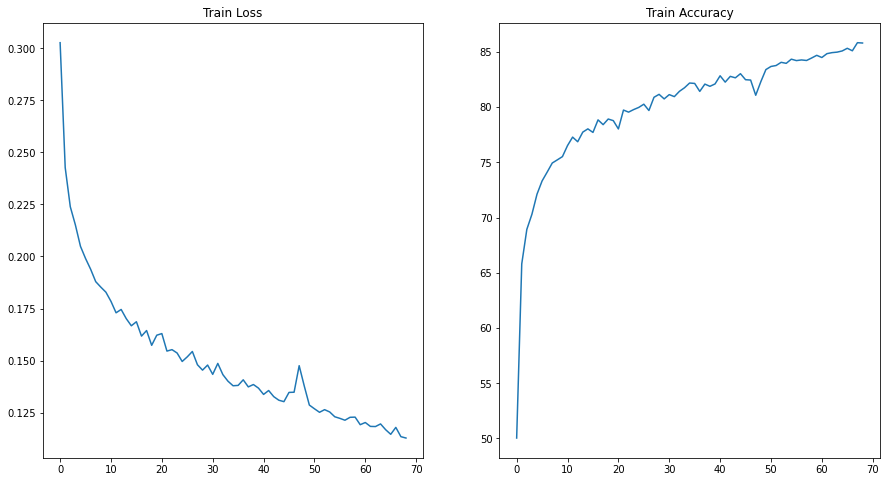

In [18]:
plt.suptitle("Train")

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(losses_train)

plt.subplot(1, 2, 2)
plt.title("Train Accuracy")
plt.plot(accs_train)

<Figure size 432x288 with 0 Axes>

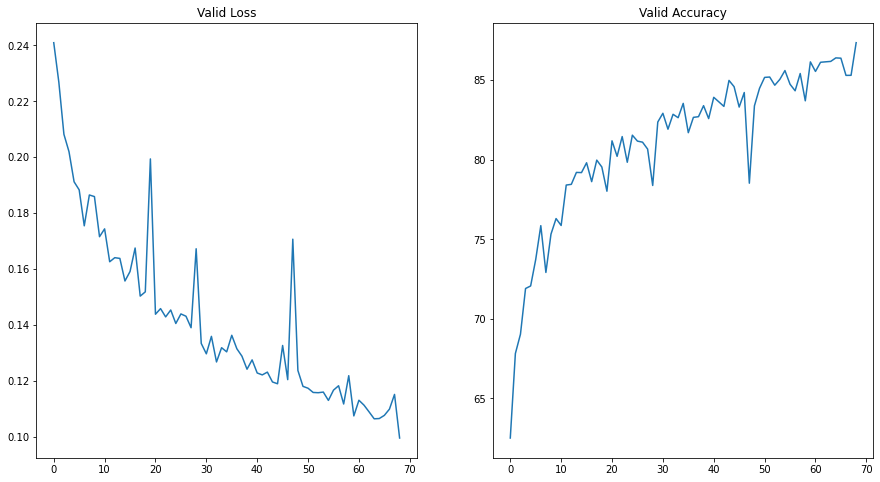

In [19]:
plt.suptitle("Valid")

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.title("Valid Loss")
plt.plot(losses_valid)

plt.subplot(1, 2, 2)
plt.title("Valid Accuracy")
plt.plot(accs_valid)

In [20]:
torch.save(densenet,'./Shahar_DenseNetPreTrainedModel.h5')

In [21]:
# torch.save({
#             'model_state_dict': googlenet_model.state_dict(),
#             'optimizer_state_dict': opt.state_dict(),
#             }, './Shahar_GoogleNetPreTrainedModel.h5')